# #2 Analyze sentiment of foreign text with Amazon Translate and Amazon Comprehend

This module walks you through how to analyze the sentiment or emotive tone of foreign text.



## Outline of Module #2

* Project Introduction
* Sentiment Analysis and Supervised Learning
* Amazon Services in this solution
* Machine Learning Process
* Before you begin
* Tutorial
* When you're done


## Project Introduction

Imagine you have a customer, a teenager who recently moved to France for her father's job. She's made a couple of local friends in her high school. Since her friends are active on Twitter, she makes an account. 

However, all the tweets are in French. She struggles to tell which tweets are jokes or serious, as well as angry or happy. She wants an app to quickly gauge the sentiment of social media posts so she can keep up with her friends.


Your customer's problem can be addressed with another technique in natural language processing, sentiment analysis. 

## Sentiment Analysis and Supervised Learning

_Sentiment analysis_ is the process of detecting whether a given piece of text is positive, negative, or neutral in its emotive tone. Sentiment analysis models are trained through a process called _supervised learning._ Supervised learning is modeling the features of a subject or entity. Amazon Comprehend already includes a trained model for sentiment analysis. This process of supervised learning in sentiment analysis involves training on textual features of a piece of text and predicting a class outcome of text as either positive, neutral, or negative.

# Amazon Services in this solution

## Amazon Comprehend

Amazon Comprehend can develop real-time insights by recognizing the entities, key phrases, language, sentiments, and other common elements in a document. The service can also build customized NLP models on your behalf, using the data that you provide

Comprehend simplifies the steps of a machine learning problem. You can either provide it a single document to analyze, or a set of documents to train and then classify the sentiment of input. 

## Amazon Translate

Amazon Translate is a neural machine translation service that delivers fast and customizable language translation. It  automates translation tasks such as localizing content for different geographic locations and translating large volumes of text for analysis. 

In this module, you use Amazon Translate to test your classifier with French input.


## Machine Learning Process

When you apply any machine learning model, you generally go through the following process:

1. **Pre-process data.** Gather the data that you want to find patterns in. Examples of data can include numbers and images. You may need to edit your data, such as resizing images to be the same size, or removing null values. In this project, you will sample datapoints from the dataset. 
2. **Train the model on the dataset.** Train a model using the pre-processed dataset. This is where the computer learns about which patterns in the data lead to the outcome you want to predict. In this module, you will train Comprehend's model on your dataset of tweets. 
3. **Test the model.** The model has trained on past examples of data, so test it on data it hasn't seen before. If you're working with images of cats and dogs, show it an image of a cat it hasn't seen before. In this module, Comprehend will automatically test the model once it trains on your data input.
4. **Evaluate the model.** Evaluate how well the model performed on new data points. Use metrics such as accuracy, the proportion of predictions the model got correct. In this module, Comprehend evaluates the classifier by calculating accuracy, precision, recall, and F1 score. 

## Before you Begin

Each of the Jupyter notebooks in this repository requires an _execution role_. An execution role is the role that gives SageMaker permission to perform operations on your behalf. You will use Amazon Translate and Amazon Comprehend in this notebook. You will need to grant permissions to access the services you want to use. For more information, see [Identity and Access Management (IAM) roles required for Amazon Comprehend](https://docs.aws.amazon.com/IAM/latest/UserGuide/id.html).

In order to set up your role policies, complete the following steps:

1. On the [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker), choose this **Introduction to AWS NLP** notebook instance. 
3. Scroll to **Permissions and encryption** and choose the IAM role ARN hyperlink. 
3. Choose **Attach policies.** 
4. Search up and select the policies "TranslateFullAccess" and  "ComprehendFullAccess." 
5. Choose **Attach policy.**

### Add a trust relationship to execution role  

1. On the same IAM role, choose the tab `Trust relationships`.
2. Choose `Edit trust relationship`. 
3. Copy the policy shown in the cell below. Paste into the policy editor. 


# Tutorial: Solving the problem of analyzing the sentiment of foreign text




Here are the steps you will take in order to analyze sentiment of foreign text with Amazon Comprehend. 

1. Get Familiar with Sentiment Analysis Function
2. Pre-process data
3. Store Dataset
4. Set Up Variables
5. Create Classifier
6. Call Classifier
7. Create Endpoint
8. Call Amazon Translate
9. Evaluate Model

Below is a diagram of how you will interact with Amazon Comprehend and Amazon Translate. 



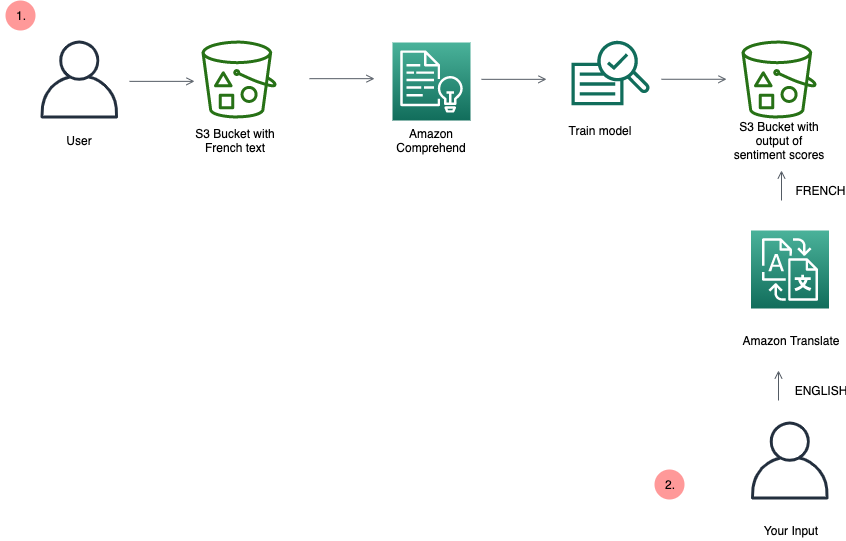

1. For Amazon Comprehend, you will upload a French dataset into a bucket and use it to train a custom classifier using Amazon Comprehend. 

2. You will test out your trained model with new custom French text. You will use Amazon Translate to convert English input into French output that can be classified as negative or positive using your trained classifier. 

## 1. Get Familiar with Sentiment Analysis Function 

Import the `boto3` SDK. Import the `pandas` package to work with the dataset in a tabular structure of rows and columns.

In [1]:
import uuid
import boto3
import pandas as pd 
import sagemaker
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()

In [3]:
print("region: {}".format(region))
print("role: {}".format(role))

region: us-east-1
role: arn:aws:iam::431424508151:role/service-role/AmazonSageMaker-ExecutionRole-20210618T151291


First, get familiar with Amazon Comprehend's out-of-the-box sentiment analysis function.

In [4]:
# Set up the Amazon Comprehend client
client = boto3.client('comprehend', region_name=region)
# French for "I am upset."
txt = "Je suis contrarié" 
# Set 'fr' for LanguageCode, as the text is in French
client.detect_sentiment(Text=txt, LanguageCode = 'fr')

{'Sentiment': 'NEGATIVE',
 'SentimentScore': {'Positive': 0.00012353650527074933,
  'Negative': 0.9995118379592896,
  'Neutral': 0.00033883837750181556,
  'Mixed': 2.5799658033065498e-05},
 'ResponseMetadata': {'RequestId': 'f4d8e54f-1c12-4ae7-818f-9d29d83fef0a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f4d8e54f-1c12-4ae7-818f-9d29d83fef0a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '168',
   'date': 'Mon, 16 Aug 2021 19:08:34 GMT'},
  'RetryAttempts': 0}}

The `detect_sentiment` function outputs a sentiment score which predicts whether the text is positive, neutral, mixed, or in this case, negative. Under 'SentimentScore,' each type of sentiment is given a confidence level, with higher decimal numbers indicating higher confidence. 

This code works well for general cases. However, often you work in domains that use specific words, such as product names or places.  You can also customize Amazon Comprehend to work for your specific problems. In this case, the social media posts contain recent slang terms that might have different sentiments than what the Comprehend model has been trained on. 

You'll next work through the process of solving a machine learning problem.

## 2. Datasets

You will store your dataset in a **bucket** using Amazon S3. First, you'll download the dataset from a public S3 bucket. Then you'll preprocess the data, and store this in your S3 bucket that was created for you when you started up your SageMaker session.

### Introduction to Amazon S3  

Amazon S3 is a service that can store and retrieve any amount of data, at any time, from anywhere on the web. You create containers known as **buckets** to store data. Then, you can manage permissions for who can access the data within the bucket. The files within a bucket are called **objects**. For more information about Amazon S3, refer to the [Amazon S3 User Guide](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html).

In [5]:
# the bucket that was created for you
bucket = sagemaker_session.default_bucket()
print("bucket: {}".format(bucket))

bucket: sagemaker-us-east-1-431424508151


You can use SageMaker's S3 utility functions to download and upload from S3. The following downloads the dataset from a public bucket and places it into a `data` folder here on your notebook instance.

In [6]:
# TODO: get the dataset in a production bucket
sagemaker.s3.S3Downloader.download(f"s3://sagemaker-sample-files/datasets/text/french_tweet_sentiment/french_tweets.csv", "data")

## 3. Pre-process data
Before you can train your model, you need to **pre-process** your data. Take a look at the data by running the code snippet below.

In [7]:
# Set encoding because dataset has encoding types that UTF-8 can't handle
# Set low_memory=False due to warning about mixed data types
df = pd.read_csv(
                filepath_or_buffer='data/french_tweets.csv',
                usecols=[0,1], 
                header=0,
                encoding = "ISO-8859-1",
                low_memory=False)
# Print out a snippet of the dataset that you will process. 
print(df) 

        0                                   parle-moi de Ã§a
0       1  Salut david ... j'ai regardÃ© ... mangez bulag...
1       0  Joyeuse fÃªte des mÃ¨res ... Tu me manques la ...
2       0  Craint d'aller au dentiste pour avoir un Ã©cra...
3       1  Le crapaud est vraiment ... je ne connais pas ...
4       1  Bien sÃ»r, j'aurai un deuxiÃ¨me latte en votre...
...    ..                                                ...
499994  0   Je ne veux pas aller Ã  l'Ã©cole pour le moment.
499995  0  Livres, vÃ©rifiez! Mais autrement que non, ma ...
499996  0         Vous, oÃ¹ Ã  mtl? .. et je vous ai manquÃ©
499997  0  Omg ... hope ty va bien. J'espÃ¨re que ce n'Ã©...
499998  0  A travaillÃ© aujourd'hui. Avec des crampes. Je...

[499999 rows x 2 columns]


Each row is an example of a data point from the dataset. The written text of the French tweet is under the third "text" column. The second "label" column is the output label the model wants to learn how to predict. "0" indicates a negative tweet and "1" indicates a positive tweet. 


Comprehend can accept a maximum of 1,000,000 lines for a file. The total size of the dataset can be 5GB. Let's sample 1,000,000 lines from the dataset. 

In [8]:
df = df.sample(n=100000)

Convert your dataset sample
into a file, and then read into the file again. Amazon Comprehend requires a dataset without a header row. 

In [9]:
# Input your own file name for the file
file_name = 'french_text.csv' 
df.to_csv(file_name, header=False, index=False)

In [10]:
df = pd.read_csv(file_name,usecols=[0,1], header=0)

Now, your dataset is prepared. Next, you upload the dataset to your personal bucket. You access the bucket through a _S3Uri._ An _S3URI_ identifies the bucket you want to access. The format of your bucket URI is `s3://bucket_name/file_name.`

In [11]:
# The S3Uri string combines your bucket name and file name. 
s3_uri = "s3://{}/comprehend-sentiment-example/data".format(bucket)
s3_uri_input = sagemaker.s3.S3Uploader.upload(file_name, s3_uri)

In [12]:
print(s3_uri_input)

s3://sagemaker-us-east-1-431424508151/comprehend-sentiment-example/data/french_text.csv


## 4. Create document classifier

Now, you are ready to create your document classifier. 

The document classifier is the custom model that will train on the document of French tweets and learn how to predict whether a tweet is negative or positive. 

You will use the `CreateDocumentClassifier` function, which you can learn more about in the [Amazon Comprehend Developer Guide](https://docs.aws.amazon.com/comprehend/latest/dg/API_CreateDocumentClassifier.html). This code cell may take a few minutes to run. 

In [13]:
# Generate a random unique id for your DocumentClassifierName
id = str(uuid.uuid4())
# Create a document classifier
create_response = client.create_document_classifier(
    InputDataConfig={
        'S3Uri': s3_uri_input
    },
    DataAccessRoleArn = role,
    DocumentClassifierName=id,
    LanguageCode='en'
)
print("Create response: %s\n", create_response)


Create response: %s
 {'DocumentClassifierArn': 'arn:aws:comprehend:us-east-1:431424508151:document-classifier/fe5fe4d0-c509-4c6b-9eaa-7341452cd731', 'ResponseMetadata': {'RequestId': '5f5b2eee-309c-4bcb-ac2e-d2a831dc4d0e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '5f5b2eee-309c-4bcb-ac2e-d2a831dc4d0e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '126', 'date': 'Mon, 16 Aug 2021 19:09:23 GMT'}, 'RetryAttempts': 0}}


Comprehend returns the DocumentClassifierArn in the response of the CreateDocumentClassifier API call. 

It will take around an hour for your classifier to train. 

There are two ways to check when you classifier is trained. 
1. Run the code cell below. Re-rerun it when you want to check the status. 
2. Check the status of your training job in the [Comprehend Console](https://console.aws.amazon.com/comprehend). 

In [40]:
DocumentClassifierArn=create_response['DocumentClassifierArn']
# Check the status of the classifier
describe_response = client.describe_document_classifier(
    DocumentClassifierArn=create_response['DocumentClassifierArn'])
print("Describe response: %s\n", describe_response)

print("\nThe status of your classifier is: " + describe_response['DocumentClassifierProperties']['Status'])

Describe response: %s
 {'DocumentClassifierProperties': {'DocumentClassifierArn': 'arn:aws:comprehend:us-east-1:431424508151:document-classifier/6a01996b-e897-45d4-9f0f-9fd2b9dcdf06', 'LanguageCode': 'en', 'Status': 'TRAINING', 'SubmitTime': datetime.datetime(2021, 8, 16, 17, 50, 20, 86000, tzinfo=tzlocal()), 'InputDataConfig': {'DataFormat': 'COMPREHEND_CSV', 'S3Uri': 's3://sagemaker-us-east-1-431424508151/comprehend-sentiment-example/data/french_text.csv'}, 'OutputDataConfig': {}, 'DataAccessRoleArn': 'arn:aws:iam::431424508151:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole', 'Mode': 'MULTI_CLASS'}, 'ResponseMetadata': {'RequestId': 'a8699f3a-d2a8-4024-ba20-1ac002300102', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'a8699f3a-d2a8-4024-ba20-1ac002300102', 'content-type': 'application/x-amz-json-1.1', 'content-length': '531', 'date': 'Mon, 16 Aug 2021 17:55:05 GMT'}, 'RetryAttempts': 0}}

The status of your classifier is: TRAINING


When the status goes from `Training` to `Trained`, you are ready to move to the next step.

## 5. Evaluate model

You can see how well your model performed in terms of what your model predicted as the sentiment for a piece of text versus the actual sentiment.

Go to the [Amazon Comprehend Console](https://console.aws.amazon.com/comprehend/) and choose your unique classifier. Scroll to **Classifier performance.** 


This is a metric of success of how accurately the model can classify a tweet as negative or positive. A higher decimal number indicates a better model performance. 


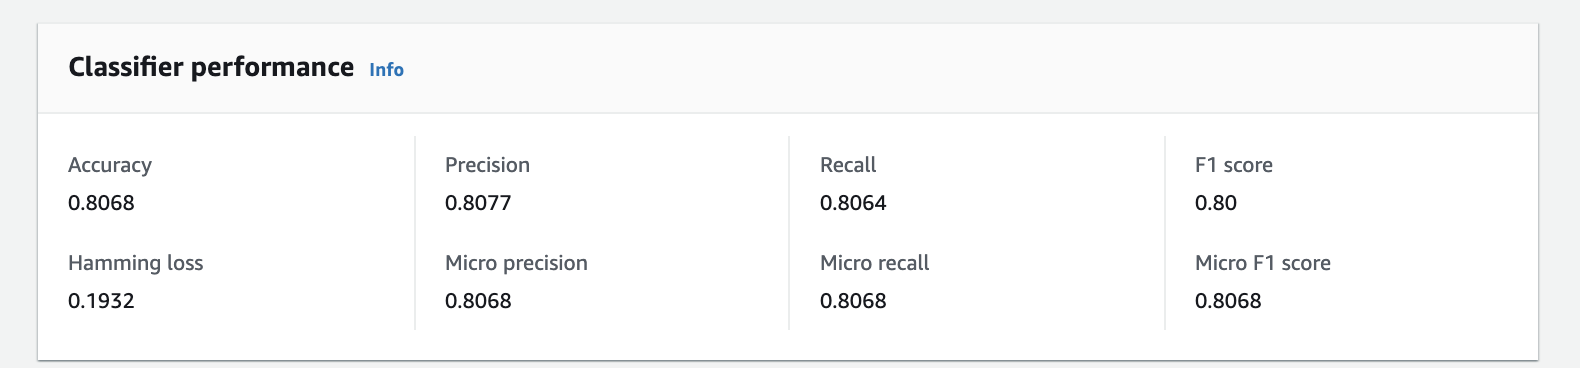

## 6. Call classifier

Now that you set up your classifier, start your classification job. 

Set up a S3 Bucket to hold the output of the classification. 

In [11]:
# active session going still
#sess_output = sagemaker.Session()
# active bucket still
#output_bucket = sess.default_bucket()                    # Set a default S3 bucket
# Since we're creating a new file, create a file called 'output'
s3_uri_output = "s3://{}/comprehend-sentiment-example/data/output".format(bucket)
print(s3_uri_output)
print(DocumentClassifierArn)

s3://sagemaker-us-east-1-431424508151/comprehend-sentiment-example/data/output


NameError: name 'DocumentClassifierArn' is not defined

In [27]:
# Instantiate Boto3 SDK:
# still active
#client = boto3.client('comprehend')

start_response = client.start_document_classification_job(
    InputDataConfig={
        'S3Uri': s3_uri_input,
        'InputFormat': 'ONE_DOC_PER_LINE'
    },
    OutputDataConfig={
        'S3Uri': s3_uri_output
    },
    #DataAccessRoleArn=CustomDataAccessRoleArn,
    DataAccessRoleArn=role,
    DocumentClassifierArn=DocumentClassifierArn
    
)

print("Start response: %s\n", start_response)

# Check the status of the job
describe_response = client.describe_document_classification_job(JobId=start_response['JobId'])
print("Describe response: %s\n", describe_response)


ResourceUnavailableException: An error occurred (ResourceUnavailableException) when calling the StartDocumentClassificationJob operation: CLASSIFIER_NOT_TRAINED_MESSAGE: Classifier (Optional[arn:aws:comprehend:us-east-1:688520471316:document-classifier/2f66fb73-c5ac-4cdc-b056-37e993cd4837]) must have trained status.

Note that you will need to wait around an hour for the classifier to train. If you want to check the status of your classifier, go to the Amazon Comprehend Console. 

## 7. Create Endpoint

After your classifier has been created and trained, you need to create an endpoint to enable real-time analysis. You will be able to input any text and classify whether it has positive or negative sentiment. 

To create an endpoint, complete the following steps: 
1. On the [Amazon Comprehend Console](https://console.aws.amazon.com/comprehend/), choose **Custom Classification.** 
2. Click on the unique classifier that you named earlier. 
3. Click **Create endpoint.** 
4. Put 1 for number of inference units. 
5. Wait a few minutes for the endpoint to be created. 
6. Copy the ARN of the endpoint. 

For more information, see [creating an endpoint](https://docs.aws.amazon.com/comprehend/latest/dg/create-endpoint.html).

In [ ]:
# Input your own endpoint ARN
endpoint_arn = 'arn:aws:comprehend:us-east-1:${accountID}:document-classifier-endpoint/${endpointName}'


Now you can test your custom classifier, which has been trained to predict the labels of '1' or '0' (meaning 'positive' or 'negative'). 

In [ ]:
txt = "Je suis contrarié" # French for "I am upset."
response = client.classify_document(Text=txt,EndpointArn=endpoint_arn)
response['Classes']


The above code cell outputs two results. The `score` output for '0' is the probability the text has negative sentiment. 
The second `score` output is the probability the text has positive sentiment. 

## 8. Call Amazon Translate

In order to test your model with different French inputs, call the Amazon Translate client. Input your desired text in English. See how different inputs get different results.  

In [ ]:
custom_txt = "" # Fill in with any English text input
# Client represents Amazon Translate, and is used for specific functions later on. 
client_translate = boto3.client('translate')

# Calls the translate function. 
french_response = client_translate.translate_text(
        Text=customtxt, 
        SourceLanguageCode='en', 
        TargetLanguageCode='fr' 
    )

response_custom = client.classify_document(Text=custom_txt, EndpointArn = endpoint_arn)
response_custom['Classes']

You have trained a custom classifier to classify a given text as 'positive' or 'negative.' You have went through the process of breaking down a machine learning problem, from data pre-processing to testing the model. Now, you can apply this process to any custom text dataset that you have. 
 

## When you're done 
In the next module, you will explore AWS products that use computer vision and detext foreign text from a document. 

Navigate back to the main folder in JupyterLab. Choose **Module #3**. Then, choose the Jupyter Notebook "#3 Extract and translate foreign text from an image with Amazon Translate and Amazon Textract" to proceed to the next module. 